# 2D ring resonator

See on [github](https://github.com/flexcompute/tidy3d-notebooks/blob/main/RingResonator.ipynb), run on [colab](https://colab.research.google.com/github/flexcompute/tidy3d-notebooks/blob/main/RingResonator.ipynb), or just follow along with the output below.

This is a simple example of using Tidy3D to simulate a common photonics application.

We perform a 2D simulation of a ring resonator side coupled to a dielectric waveguide.

<img src="img/ring.png" alt="diagram" width="300"/>

With a center wavelength of 500 nm and 10 nm resolution, this is a challenging FDTD problem because of the large simulation size.  The simulation contains 1 million grid points to model the entire domain and 290,000 time steps to capture the resonance of the ring.

With Tidy3D, we perform each simulation in just a few minutes.

In [1]:
# make sure notebook plots inline
%matplotlib inline

# standard python imports
import numpy as np
from numpy import random
import matplotlib.pyplot as plt

# tidy3D import
import sys
sys.path.append('../../tidy3d')
import tidy3d.web as web
import tidy3d as td

## Initial setup

Our ring resonator will include a ring centered at (0,0) with a waveguide just above the ring spanning the x direction.

```    
                      (waveguide)      
                in -> ========== -> out
                           0
                      (resonator)
   ```

In [2]:
# resolution
dl = 0.01

# define geometry
wg_width = 0.25
couple_width = 0.05
ring_radius = 3.5
ring_wg_width = 0.25
wg_spacing = 2.0
buffer = 2.0

# compute quantities based on geometry parameters
x_span = 2*wg_spacing + 2*ring_radius + 2*buffer
y_span = 2*ring_radius + 2*ring_wg_width + wg_width + couple_width + 2*buffer
wg_insert_x = ring_radius + wg_spacing
wg_center_y = ring_radius + ring_wg_width/2. + couple_width + wg_width/2.

# set number of PMLs on each side
npml = 15

In [3]:
# define pulse parameters
pol = 'TE'  # 'TE' or 'TM'.  TE means waveguide excited Ey, TM means waveguide excited Ez
lambda_central = 0.5
f_center = td.C_0 /lambda_central
f_width =  f_center / 6
grids_per_wavelength = lambda_central / dl
run_time_norm = 1e-13  # run time for normalization run without ring
run_time = 5e-12       # run time for simulation with ring

Define materials. [(docs)](https://simulation.cloud/docs/html/api.html#material)

In [4]:
n_bg = 1.0
n_solid = 1.5
background = td.Medium(permittivity=n_bg**2)
solid = td.Medium(permittivity=n_solid**2)

Define structures. [(docs)](https://simulation.cloud/docs/html/api.html#structure)


In [5]:
# background of entire domain (set explicitly as a box)
background_box = td.Structure(
    geometry=td.Box(
        center=[0, 0, 0],
        size=[td.inf, td.inf, td.inf],
    ),
    medium=background,
    name='background')

# waveguide
waveguide = td.Structure(
    geometry=td.Box(
        center=[0, wg_center_y, 0],
        size=[td.inf, wg_width, td.inf],
    ),
    medium=solid,
    name='waveguide')

# outside ring
outer_ring = td.Structure(
    geometry=td.Cylinder(
        center=[0,0,0],
        axis=2,
        radius=ring_radius+ring_wg_width/2.0,
        length=td.inf,
    ),
    medium=solid,
    name='outer_ring')

# inside ring fill
inner_ring = td.Structure(
    geometry=td.Cylinder(
        center=[0,0,0],
        axis=2,
        radius=ring_radius-ring_wg_width/2.0,
        length=td.inf,
    ),
    medium=background,
    name='inner_ring')

In [9]:
from tidy3d.plugins import ModeSolver

mode_plane = td.Box(
    center=[-wg_insert_x, wg_center_y, 0],
    size=[0, 2, td.inf],
)

sim_modesolver = td.Simulation(
    size=[x_span, y_span, 1*dl],
    grid_size=[dl, dl, dl],
    structures=[background_box, waveguide],
)

mode_solver = ModeSolver(simulation=sim_modesolver, plane=mode_plane, freq=f_center)
mode_data_0 = mode_solver.solve(mode=td.Mode(mode_index=0))
mode_data_1 = mode_solver.solve(mode=td.Mode(mode_index=1))

mode_data_0.field_data['Ey']

<xarray.DataArray (x: 1, y: 201, z: 1, f: 1)>
array([[[[ 2.11406357e-17-4.72254591e-17j]],

 [[ 1.59906554e-17-5.09184353e-17j]],

 [[ 1.34417400e-17-4.64111192e-17j]],

 [[ 1.28492569e-17-4.63982185e-17j]],

 [[ 1.38787207e-17-2.76743964e-17j]],

 [[-4.53317235e-18-4.20501364e-17j]],

 [[ 3.65701007e-17-4.16012394e-17j]],

 [[ 1.55852490e-17-4.40081898e-17j]],

 [[ 3.69727496e-17-2.18564673e-17j]],

 [[ 1.07756319e-17-3.31022620e-17j]],

...

 [[-3.53417133e-17-1.17597647e-17j]],

 [[-3.94120369e-17+1.85586905e-17j]],

 [[-4.89945236e-17+8.43735689e-18j]],

 [[-4.29604007e-17+2.82932559e-17j]],

 [[-5.72194883e-17+1.84240558e-17j]],

 [[-3.32096035e-17+3.34781944e-17j]],

 [[-5.43338224e-17+3.00141685e-17j]],

 [[-5.66183013e-17+3.24513828e-17j]],

 [[-5.49333377e-17+2.65548096e-17j]],

 [[-3.94583253e-17+1.18859363e-17j]]]])
Coordinates:
 * x (x) float64 -5.5
 * y (y) float64 2.795 2.805 2.815 2.825 ... 4.765 4.775 4.785 4.795
 * z (z) float64 -0.005
 * f (f) float64 5.996e+14 xarray.DataArray x : 1 y : 201 z : 1 f : 1 (2.1140635710308444e-17-4.722545914117978e-17j) ... (-3.94583252520... array([[[[ 2.11406357e-17-4.72254591e-17j]],

 [[ 1.59906554e-17-5.09184353e-17j]],

 [[ 1.34417400e-17-4.64111192e-17j]],

 [[ 1.28492569e-17-4.63982185e-17j]],

 [[ 1.38787207e-17-2.76743964e-17j]],

 [[-4.53317235e-18-4.20501364e-17j]],

 [[ 3.65701007e-17-4.16012394e-17j]],

 [[ 1.55852490e-17-4.40081898e-17j]],

 [[ 3.69727496e-17-2.18564673e-17j]],

 [[ 1.07756319e-17-3.31022620e-17j]],

...

 [[-3.53417133e-17-1.17597647e-17j]],

 [[-3.94120369e-17+1.85586905e-17j]],

 [[-4.89945236e-17+8.43735689e-18j]],

 [[-4.29604007e-17+2.82932559e-17j]],

 [[-5.72194883e-17+1.84240558e-17j]],

 [[-3.32096035e-17+3.34781944e-17j]],

 [[-5.43338224e-17+3.00141685e-17j]],

 [[-5.66183013e-17+3.24513828e-17j]],

 [[-5.49333377e-17+2.65548096e-17j]],

 [[-3.94583253e-17+1.18859363e-17j]]]]) Coordinates: (4) x (x) float64 -5.5 array([-5.5]) y (y) float64 2.795 2.805 2.815 ... 4.785 4.795 array([2.795, 2.805, 2.815, ..., 4.775, 4.785, 4.795]) z (z) float64 -0.005 array([-0.005]) f (f) float64 5.996e+14 array([5.995849e+14]) Attributes: (0)

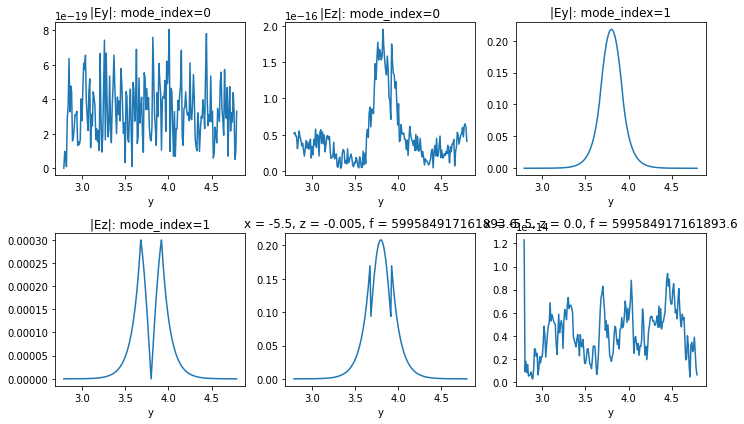

In [22]:
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, tight_layout=True, figsize=(10, 6))
abs(mode_data_0.field_data['Ex']).sel(f=f_center).plot(ax=ax1)
abs(mode_data_0.field_data['Ey']).sel(f=f_center).plot(ax=ax2)
abs(mode_data_0.field_data['Ez']).sel(f=f_center).plot(ax=ax3)
abs(mode_data_1.field_data['Ex']).sel(f=f_center).plot(ax=ax4)
abs(mode_data_1.field_data['Ey']).sel(f=f_center).plot(ax=ax5)
abs(mode_data_1.field_data['Ez']).sel(f=f_center).plot(ax=ax6)
ax1.set_title('|Ey|: mode_index=0')
ax2.set_title('|Ez|: mode_index=0')
ax3.set_title('|Ey|: mode_index=1')
ax4.set_title('|Ez|: mode_index=1')
plt.show()

From the above plots, we see that 

`mode_index=0` corresponds to exciting 0-th order TM mode (E=Ez) and 

`mode_index=1` corresponds to exciting 0-th order TE mode (E=Ey).

We can therefore switch the mode index accordingly based on our polarization.

Let's select Ey and create the source for it.

In [7]:
mode_source = mode_solver.make_source(mode=td.Mode(mode_index=1), fwidth=f_center/5, direction="+")

Define modal source. [(docs)](https://simulation.cloud/docs/html/api.html#source)

Define monitors. [(docs)](https://simulation.cloud/docs/html/api.html#monitor)

In [8]:
# monitor steady state fields at central frequency over whole domain
field_monitor = td.FieldMonitor(
    center=[0, 0, 0],
    size=[x_span, y_span, 0],
    freqs=[f_center],
    name='full_domain_fields')

# monitor the time series at a point in the center of the output waveguide
time_monitor = td.FieldTimeMonitor(
    center=[wg_insert_x, wg_center_y, 0],
    size=[0, 0, 0],
    name='time_series')

Define simulation. [(docs)](https://simulation.cloud/docs/html/api.html#simulation)

Here, we turn off the automatic shutoff factor by setting it to 0. This is because we will compute the spectrum by a fourier transform of the time response, and we would like to run the normalization simulation and the simulation with ring to exactly the same `run_time`.

In [9]:
# create normalization simulation (no ring)
sim0 = td.Simulation(
    size=[x_span, y_span, 1*dl],
    grid_size=[dl, dl, dl],
    structures=[background_box, waveguide],
    sources=[mode_source],
    monitors=[field_monitor, time_monitor],
    run_time = run_time_norm,
    pml_layers=[td.PML(), td.PML(), None])

# create simulation (with ring)
sim = td.Simulation(
    size=[x_span, y_span, 1*dl],
    grid_size=[dl, dl, dl],
    structures=[background_box, waveguide, outer_ring, inner_ring],
    sources=[mode_source],
    monitors=[field_monitor, time_monitor],
    run_time = run_time,
    pml_layers=[td.PML(), td.PML(), None])

----
Visualize structure, source, and modes. [(docs)](https://simulation.cloud/docs/html/api.html#plotting-tools)

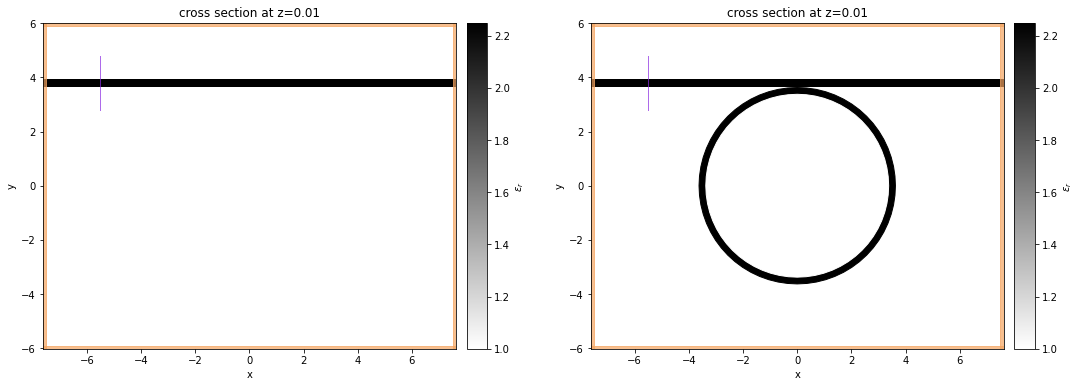

In [10]:
# plot the two simulations
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
sim0.plot_eps(z=0.01, ax=ax1)
sim.plot_eps(z=0.01, ax=ax2)
plt.show()

----
## Run Simulation
Run simulations on our server. [(docs)](https://simulation.cloud/docs/html/api.html#web-api)

In [11]:
# use function above to run simulation with and without ring
sim_data0 = web.run(sim0, task_name='normalization', path='data/simulation_data0.hdf5')
sim_data = web.run(sim, task_name='with_ring', path='data/simulation_data.hdf5')

[09:40:19] INFO     Creating task.                                              ]8;id=666889;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/docs/notebooks/../../tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:346

[09:40:20] INFO     Uploading the json file                                     ]8;id=506976;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/docs/notebooks/../../tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:355

Output()

[09:40:22] status = queued                                                      ]8;id=656338;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:171

[09:40:30] status = preprocess                                                  ]8;id=5427;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:171

[09:46:03] status = running                                                     ]8;id=100791;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:171

[09:47:29] status = visualize                                                   ]8;id=858558;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:171

[09:47:33] status = success                                                     ]8;id=24733;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:171

[09:47:34] INFO     clearing existing files before downloading                  ]8;id=38550;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/docs/notebooks/../../tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:235

           INFO     downloading file "simulation.json" to                       ]8;id=589122;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/docs/notebooks/../../tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:388
                    "data/simulation.json"

Output()

           INFO     downloading file "monitor_data.hdf5" to                     ]8;id=58829;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/docs/notebooks/../../tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:388
                    "data/monitor_data.hdf5"

Output()

[09:47:45] INFO     getting log string                                          ]8;id=182545;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/docs/notebooks/../../tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:244

           INFO     downloading file "tidy3d.log" to "data/tidy3d.log"          ]8;id=216285;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/docs/notebooks/../../tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:388

Output()

           INFO     loading old monitor data to data dict                       ]8;id=374224;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/docs/notebooks/../../tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:249

           INFO     creating SimulationData from monitor data dict              ]8;id=705685;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/docs/notebooks/../../tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:254

           INFO     exporting SimulationData to data/simulation_data0.hdf5      ]8;id=860077;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/docs/notebooks/../../tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:261

[09:47:46] INFO     clearing extraneous files                                   ]8;id=279966;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/docs/notebooks/../../tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:264

           INFO     removing file data/simulation.json                          ]8;id=990917;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/docs/notebooks/../../tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:419

           INFO     removing file data/monitor_data.hdf5                        ]8;id=967460;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/docs/notebooks/../../tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:419

           INFO     removing file data/tidy3d.log                               ]8;id=119859;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/docs/notebooks/../../tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:419

           INFO     loading SimulationData from data/simulation_data0.hdf5      ]8;id=966966;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/docs/notebooks/../../tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:297

           INFO     Creating task.                                              ]8;id=381672;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/docs/notebooks/../../tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:346

           INFO     Uploading the json file                                     ]8;id=717942;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/docs/notebooks/../../tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:355

Output()

[09:47:48] status = queued                                                      ]8;id=278160;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:171

[09:48:03] status = preprocess                                                  ]8;id=968747;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:171

[09:59:38] status = running                                                     ]8;id=450586;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:171

[10:01:51] status = postprocess                                                 ]8;id=446774;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:171

[10:01:52] status = visualize                                                   ]8;id=831612;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:171

[10:01:56] INFO     clearing existing files before downloading                  ]8;id=873212;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/docs/notebooks/../../tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:235

           INFO     removing file data/simulation_data.hdf5                     ]8;id=80156;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/docs/notebooks/../../tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:419

           INFO     downloading file "simulation.json" to                       ]8;id=312094;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/docs/notebooks/../../tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:388
                    "data/simulation.json"

Output()

[10:01:57] INFO     downloading file "monitor_data.hdf5" to                     ]8;id=538232;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/docs/notebooks/../../tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:388
                    "data/monitor_data.hdf5"

Output()

[10:02:07] INFO     getting log string                                          ]8;id=133010;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/docs/notebooks/../../tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:244

           INFO     downloading file "tidy3d.log" to "data/tidy3d.log"          ]8;id=917781;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/docs/notebooks/../../tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:388

Output()

[10:02:08] INFO     loading old monitor data to data dict                       ]8;id=478631;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/docs/notebooks/../../tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:249

           INFO     creating SimulationData from monitor data dict              ]8;id=306569;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/docs/notebooks/../../tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:254

           INFO     exporting SimulationData to data/simulation_data.hdf5       ]8;id=984318;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/docs/notebooks/../../tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:261

           INFO     clearing extraneous files                                   ]8;id=500776;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/docs/notebooks/../../tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:264

           INFO     removing file data/simulation.json                          ]8;id=423916;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/docs/notebooks/../../tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:419

           INFO     removing file data/monitor_data.hdf5                        ]8;id=763573;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/docs/notebooks/../../tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:419

           INFO     removing file data/tidy3d.log                               ]8;id=236815;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/docs/notebooks/../../tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:419

           INFO     loading SimulationData from data/simulation_data.hdf5       ]8;id=871004;file:///Users/twhughes/Documents/Flexcompute/tidy3d-docs/docs/notebooks/../../tidy3d/tidy3d/web/webapi.py\webapi.py]8;;\:297

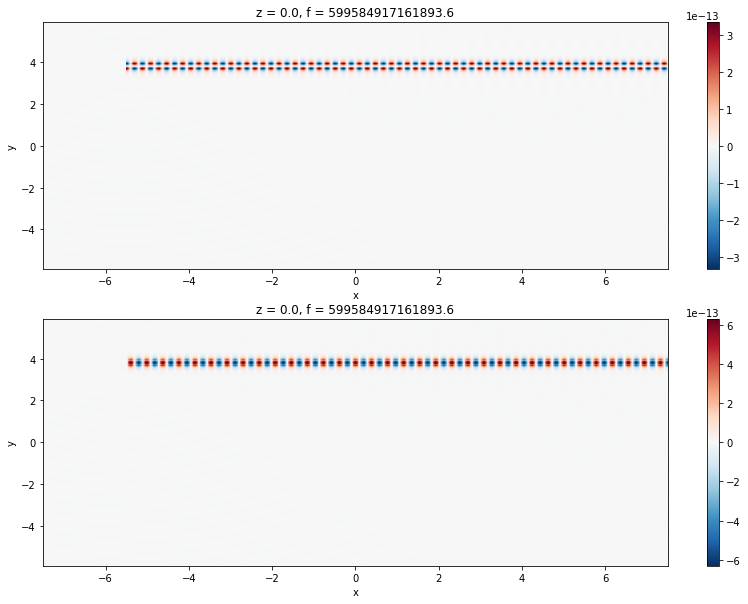

In [18]:
# visualize normalization run
comps = ('x', 'y')
fig, axes = plt.subplots(2, 1, figsize=(14, 10))
for ax, comp in zip(axes, comps):
    im = sim_data0['full_domain_fields']['E' + comp].sel(z=0, f=f_center).real.plot(x='x', y='y', ax=ax)

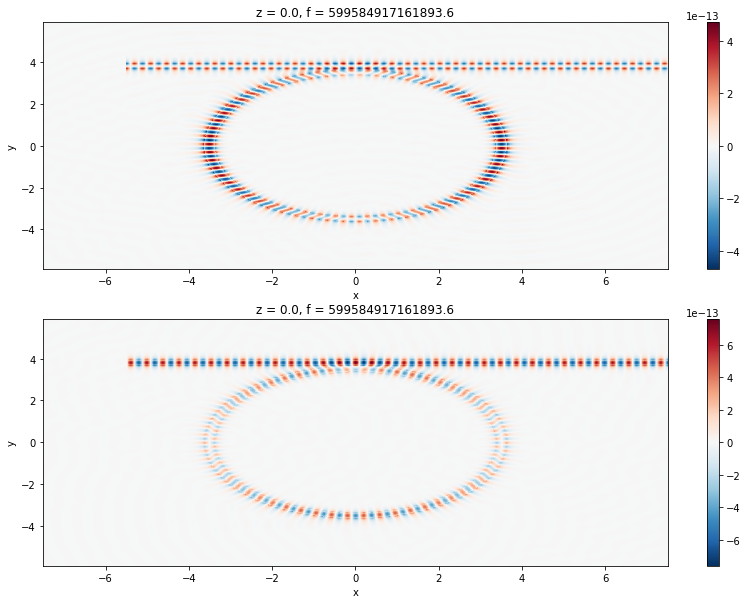

In [19]:
# visualize run with ring
fig, axes = plt.subplots(2, 1, figsize=(14, 10))
for ax, comp in zip(axes, comps):
    im = sim_data['full_domain_fields']['E' + comp].sel(z=0, f=f_center).real.plot(x='x', y='y', ax=ax)

## Analyze Spectrum
Analyze transmission spectrum using fourier transform. [(docs)](https://simulation.cloud/docs/html/api.html#miscellaneous)

In [20]:
# Get data from the TimeMonitor
tdata0 = sim0.data(time_monitor)
tdata = sim.data(time_monitor)
tmesh0 = tdata0["tmesh"]
tmesh = tdata["tmesh"]
Nt = tmesh.size
dt = tmesh[1] - tmesh[0]

# select output fields as Ez if TM or Ey if TE
field_index = 2 if pol == 'TM' else 1

E_out0 = tdata0['E'][field_index, 0, 0, 0, :]
E_out = tdata['E'][field_index, 0, 0, 0, :]

# frequencies to measure output spectrum at
freqs = td.C_0 / np.linspace(0.4, 0.6, 1000)

# fourier transform output time series to get spectrum at freqs
E_out0_f = td.dft_spectrum(E_out0, dt, freqs)
E_out_f = td.dft_spectrum(E_out, dt, freqs)

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│                                                                                           │
│ /var/folders/jx/9y0mtn3s3zzb6mzgmsw6s6gr0000gn/T/ipykernel_62270/3064023857.py:2 in       │
│ <module>                                                                                  │
│                                                                                           │
│ [Errno 2] No such file or directory:                                                      │
│ '/var/folders/jx/9y0mtn3s3zzb6mzgmsw6s6gr0000gn/T/ipykernel_62270/3064023857.py'          │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'Simulation' object has no attribute 'data'

Plot results.

In [ ]:
# plot time series with ring
fig, ax = plt.subplots(1, figsize=(8, 4), tight_layout=True)

ax.plot(tmesh, np.abs(E_out))
ax.set_xlabel("Time [s]")
ax.set_ylabel("Electric field [a.u.]");
ax.set_title("STRUCTURE $E_{out}(t)$")
ax.set_ylim((1e-4, 1e3))
ax.set_yscale('log')
ax.set_xlim((tmesh[0], tmesh[-1]));

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8), tight_layout=True)

# plot spectrum of normalization (input)
ax[0, 0].plot(freqs, np.abs(E_out0_f))
ax[0, 0].set_xlabel("Frequency [Hz]")
ax[0, 0].set_ylabel("Electric field [a.u.]");
ax[0, 0].set_title("NORMALIZE Spectrum");

# plot transmission spectrum with ring
ax[0, 1].plot(freqs, np.abs(E_out_f))
ax[0, 1].set_xlabel("Frequency [Hz]")
ax[0, 1].set_ylabel("Electric field [a.u.]");
ax[0, 1].set_title("STRUCTURE Spectrum");

# plot spectrum ratio |E_ring(f)| / |E_norm(f)|
ax[1, 0].plot(freqs, np.abs(E_out_f) / np.abs(E_out0_f))
ax[1, 0].set_xlabel("Frequency [Hz]")
ax[1, 0].set_ylabel("enhancement");
ax[1, 0].set_title("Structure / Normalize Spectrum");

# plot square of spectrum ratio ( |E_ring(f)| / |E_norm(f)| )^2
ax[1, 1].plot(freqs, (np.abs(E_out_f) / np.abs(E_out0_f))**2)
ax[1, 1].set_xlabel("Frequency [Hz]")
ax[1, 1].set_ylabel("enhancement^2");
ax[1, 1].set_title("|Structure / Normalize Spectrum|^2");

In [ ]:
# add your analysis here!